<a href="https://colab.research.google.com/github/paranjaa/ece1508-student-depression-project/blob/main/ECE1508_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
#import each one of the libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [31]:
#have to go through permissions each time this starts up
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
#need to check if this works with others
df = pd.read_csv("gdrive/My Drive/ECE1508/Project/Student_Depression_Dataset.csv")


In [33]:
df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

## Basic Correlation ##


### Dataset cleanup

In [114]:
#make a copy of the dataframe
df =  pd.read_csv("gdrive/My Drive/ECE1508/Project/Student_Depression_Dataset.csv")

In [115]:
# id: not sure why its numbered like that, probably not useful
#dropping it for now, might need it later
df = df.drop('id', axis=1)

In [116]:

## Gender: convert to one hot columns? maybe useful. Gender ratio is at 0.44, not so bad
# df["Gender"].value_counts()
#putting it in lowercase first
df = df.rename(columns={'Gender': 'gender'})
df["gender"] = df["gender"].map({"Female": 1, "Male": 0})
df["gender"] = df["gender"].astype(bool)
#also putting in lowercase

# df.head()

In [117]:
## Age: convert from float to int, no decimals. Mostly in 20s, maybe find an average
# df["Age"].value_counts()
df = df.rename(columns={'Age': 'age'})

df["age"] = df["age"].astype(int)


In [118]:
# # City: convert to one hot columns. Put the couple dozen cities with one or two students in "other"
# # df["City"].value_counts()

# city_count = df["City"].value_counts()

# #getting cities that are in less than 10 data points
# threshold = 10
# rare_cities = city_count[city_count < threshold].index

# #replace the values in City where there's something in the rare cities list with other
# #got this partially from gpt, verify how it works
# df["City"] = df["City"].where(~df["City"].isin(rare_cities), "Other")
# city_count = df["City"].value_counts()
# # df["City"].value_counts()

# #get a data frame of one-hot columns of the cities
# cities_df = pd.get_dummies(df["City"], prefix="city")
# # cities_df.head()

# #then add it onto the side of the original dataframe
# df = pd.concat([df, cities_df], axis=1)
# #remove the original cities column

# Actually, maybe too many cities to really help w/ one hot columns, disregarding it for now

df = df.drop('City', axis=1)

In [119]:
## Profession: not useful, barely anyone put anything other than "student"
# df["Profession"].value_counts()

#also dropping this one?
df = df.drop('Profession', axis=1)

In [120]:
## Academic Pressure: convert to int. 3 is most popular, followed by 5, then 4.
# df["Academic Pressure"].value_counts()
df = df.rename(columns={'Academic Pressure': 'academic_pressure'})
df["academic_pressure"] = df["academic_pressure"].astype(int)

In [121]:
# Work Pressure: Not useful. Only 3 people put anything other than 0
# df["Work Pressure"].value_counts()
df = df.drop('Work Pressure', axis=1)

In [122]:
## CGPA: Need to keep this as a float? There's 322 distinct values, but it seems useful.
## maybe separate it into brackets though
# df["CGPA"].value_counts()

#not touching this one for now, just putting it in lowercase
df = df.rename(columns={'CGPA': 'cgpa'})


In [123]:
# Study Satisfaction: Convert to int. Suprisingly close values, save for people who put 0.0
# df["Study Satisfaction"].value_counts()

df = df.rename(columns={'Study Satisfaction': 'study_satisfaction'})
df["study_satisfaction"] = df["study_satisfaction"].astype(int)


In [124]:
# Job Satisfaction: Not useful, assuming that 0.0 means N.A, and so many people put student
# df["Job Satisfaction"].value_counts()

df = df.drop('Job Satisfaction', axis=1)

In [125]:
## Sleep Duration: Convert to numeric values and one hot columns?
## it's in a weird format with things in buckets
# df["Sleep Duration"].value_counts()

#making one hot columns for these
sleep_df = pd.get_dummies(df['Sleep Duration'], prefix='sleep')
#adding them back onto the side, removing original
df = pd.concat([df, sleep_df], axis=1)
#figure out some way to name them better later on
df = df.drop('Sleep Duration', axis=1)

In [126]:
# Dietary Habits: Need one hot columns. "Unhealthy" is most popular, but only by <500
# df["Dietary Habits"].value_counts()
diet_df = pd.get_dummies(df['Dietary Habits'], prefix='diet')
df = pd.concat([df, diet_df], axis=1)
df = df.drop('Dietary Habits', axis=1)


In [127]:
## Degree: Lots of categories. Put into one hot columns? It'll make a lot of them
# df["Degree"].value_counts()
degree_df = pd.get_dummies(df['Degree'], prefix='degree')
df = pd.concat([df, degree_df], axis=1)
df = df.drop('Degree', axis=1)

In [128]:
## Have you ever had suicidal thoughts ? : Convert to binary. Almost 60% say yes, which I guess could be worse
## Also rename to something more concise than all that

# df["Have you ever had suicidal thoughts ?"].value_counts()
df = df.rename(columns={'Have you ever had suicidal thoughts ?': 'suicidal_thoughts'})
df["suicidal_thoughts"] = df["suicidal_thoughts"].map({"Yes": True, "No": False})


In [129]:
## Work/Study Hours: Most people are in the range of 10-12 hours. Convert to int.
# df["Work/Study Hours"].value_counts()
df = df.rename(columns={'Work/Study Hours': 'work_study_hours'})
df["work_study_hours"] = df["work_study_hours"].astype(int)

In [130]:
# Financial Stress: Suprisngly close, with 5.0 on top. Convert to int.
df = df.rename(columns={'Financial Stress': 'financial_stress'})
df["financial_stress"].value_counts()
#wait, this column has two values that aren't filled in, it has 27898 entries?
#filling the handful of NA values with a 5, since it's already ahead by 900 or so
df["financial_stress"] = df["financial_stress"].fillna(5.0)

df["financial_stress"] = df["financial_stress"].astype(int)

In [131]:
# Family History of Mental Illness: Also quite close numbers, convert to binary
#also rename this one
# df["Family History of Mental Illness"].value_counts()

df = df.rename(columns={"Family History of Mental Illness": "family_history"})
df["family_history"] = df["family_history"].map({"Yes": True, "No": False})

In [132]:
# Depression: Main label. More people do than don't.
# df["Depression"].value_counts()

df = df.rename(columns={"Depression": "depression"})
df["depression"] = df["depression"].astype(bool)

#put depression at the end of the list so we can get at it easily
final_column = df.pop('depression')
df['depression'] = final_column


In [133]:
#final name cleanup, put everything else in lowercase, as well as replacing any spaces
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   27901 non-null  bool   
 1   age                      27901 non-null  int64  
 2   academic_pressure        27901 non-null  int64  
 3   cgpa                     27901 non-null  float64
 4   study_satisfaction       27901 non-null  int64  
 5   suicidal_thoughts        27901 non-null  bool   
 6   work_study_hours         27901 non-null  int64  
 7   financial_stress         27901 non-null  int64  
 8   family_history           27901 non-null  bool   
 9   sleep_5_6_hours          27901 non-null  bool   
 10  sleep_7_8_hours          27901 non-null  bool   
 11  sleep_less_than_5_hours  27901 non-null  bool   
 12  sleep_more_than_8_hours  27901 non-null  bool   
 13  sleep_others             27901 non-null  bool   
 14  diet_healthy          

In [135]:
df.head()

,gender,age,academic_pressure,cgpa,study_satisfaction,suicidal_thoughts,work_study_hours,financial_stress,family_history,sleep_5_6_hours,...,degree_mba,degree_mbbs,degree_mca,degree_md,degree_me,degree_mhm,degree_msc,degree_others,degree_phd,depression
0,False,33,5,8.97,2,True,3,1,False,True,...,False,False,False,False,False,False,False,False,False,True
1,True,24,2,5.90,5,False,3,2,True,True,...,False,False,False,False,False,False,False,False,False,False
2,False,31,3,7.03,5,False,9,1,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,28,3,5.59,2,True,4,5,True,False,...,False,False,False,False,False,False,False,False,False,True
4,True,25,4,8.13,3,True,1,1,False,True,...,False,False,False,False,False,False,False,False,False,False


In [136]:
correlation_df = pd.read_csv("gdrive/My Drive/ECE1508/Project/Student_Depression_Dataset.csv")


In [137]:
pd.crosstab(correlation_df['Gender'], correlation_df['Depression'])

#difficult to see from how it's mapped, but
# similar rates of depression, about 70% have it, with men being slightly higher

Depression,0,1
Gender,,
Female,5133,7221
Male,6432,9115


In [138]:
pd.crosstab(correlation_df['Academic Pressure'], correlation_df['Depression'])
#as expected, higher academic pressure means higher chances of prediction

Depression,0,1
Academic Pressure,,
0.0,5,4
1.0,3869,932
2.0,2612,1566
3.0,2973,4489
4.0,1230,3925
5.0,876,5420


In [139]:
# pd.crosstab(df['cgpa'], df['depression'])


In [140]:
pd.crosstab(correlation_df['Study Satisfaction'], correlation_df['Depression'])
# Not as stratified as expected. Lower satisfaction means more depression
# Not as much as academic pressure, not nearly 1/6th difference

Depression,0,1
Study Satisfaction,,
0.0,4,6
1.0,1594,3857
2.0,2070,3768
3.0,2468,3353
4.0,3095,3264
5.0,2334,2088


In [141]:
pd.crosstab(correlation_df['suicidal_thoughts'], correlation_df['depression'])
#not a suprise, most people w/ suidical thoughts are also depressed

KeyError: 'suicidal_thoughts'

In [ ]:
pd.crosstab(correlation_df['work_study_hours'], correlation_df['depression'])

In [ ]:
pd.crosstab(correlation_df['financial_stress'], correlation_df['depression'])


In [ ]:
pd.crosstab(correlation_df['family_history'], correlation_df['depression'])
#more evenly matched than expected. A family history didn't add that much to the chances of having depression

In [ ]:
pd.crosstab(correlation_df['sleep'], correlation_df['depression'])


# Simple Neural Network 1

In [115]:
X = df.iloc[:, 0:-1].values #get everything except for the last column, done the cleanup
y = df.iloc[:, -1].values   # only take the last one, since it has our label

In [116]:

#trying to scale the numeric values, might improve the results:
# scaler = StandardScaler()
#try and scale the CGPA, maybe there's some weird variance?
# X[:, 1:4] = scaler.fit_transform(X[:, 1:4])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#some weird conversion with going to numpy arrays
X_train = torch.tensor(X_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))


#similar kind of reshaping for binary classification
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [117]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [118]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        #doing it this way instead
        self.model = nn.Sequential(
            nn.Linear(46, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
      return self.model(x)

In [119]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()

    training_loss_tracker = []
    testing_loss_tracker = []
    for epoch in range(num_epochs):
        total_loss = 0.0


        #do training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        avg_loss = total_loss / len(train_loader)
        training_loss_tracker.append(avg_loss)


        #do the test function at the same time

        model.eval()

        current_test_loss = 0.0

        with torch.no_grad():
           for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                current_test_loss += loss.item()


        avg_test_loss = current_test_loss / len(test_loader)
        testing_loss_tracker.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    plt.figure()
    plt.plot(range(1, num_epochs + 1), training_loss_tracker, marker='o', linestyle='-')
    plt.plot(range(1, num_epochs + 1), testing_loss_tracker, marker='x', linestyle='-')
    plt.title('Training Loss on each Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()


Epoch [1/50] - Train Loss: 0.4134, Test Loss: 0.3695
Epoch [2/50] - Train Loss: 0.3593, Test Loss: 0.3809
Epoch [3/50] - Train Loss: 0.3559, Test Loss: 0.3668
Epoch [4/50] - Train Loss: 0.3533, Test Loss: 0.3809
Epoch [5/50] - Train Loss: 0.3552, Test Loss: 0.3710
Epoch [6/50] - Train Loss: 0.3524, Test Loss: 0.3684
Epoch [7/50] - Train Loss: 0.3501, Test Loss: 0.3663
Epoch [8/50] - Train Loss: 0.3523, Test Loss: 0.3737
Epoch [9/50] - Train Loss: 0.3510, Test Loss: 0.3657
Epoch [10/50] - Train Loss: 0.3488, Test Loss: 0.3652
Epoch [11/50] - Train Loss: 0.3472, Test Loss: 0.3662
Epoch [12/50] - Train Loss: 0.3479, Test Loss: 0.3660
Epoch [13/50] - Train Loss: 0.3467, Test Loss: 0.3805
Epoch [14/50] - Train Loss: 0.3470, Test Loss: 0.3664
Epoch [15/50] - Train Loss: 0.3451, Test Loss: 0.3766
Epoch [16/50] - Train Loss: 0.3443, Test Loss: 0.3707
Epoch [17/50] - Train Loss: 0.3463, Test Loss: 0.3731
Epoch [18/50] - Train Loss: 0.3442, Test Loss: 0.3722
Epoch [19/50] - Train Loss: 0.3428, T

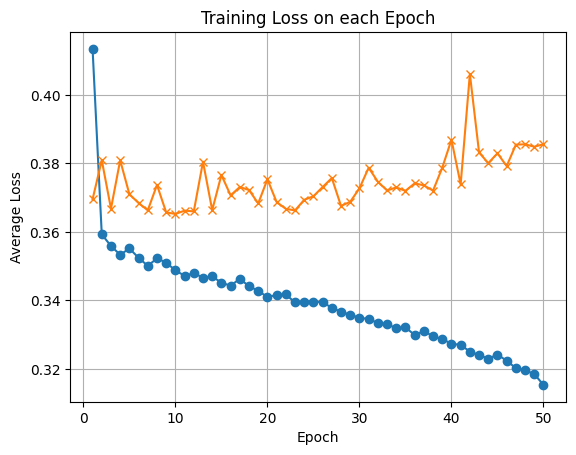

In [120]:
model = SimpleNN()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train(model, train_loader, loss_function, optimizer, num_epochs)

In [ ]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor